<a href="https://colab.research.google.com/github/Mann-05/Google-colab-ML/blob/main/Lab6-Cats-v-Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training with a Larger Dataset - Cats and Dogs

In the previous lab you trained a classifier with a horses-v-humans dataset. You saw that despite getting great training results, when you tried to do classification with real images, there were many errors, due primarily to overfitting -- where the network  does very well with data that it has previously seen, but poorly with data it hasn't!

In this lab you'll look at a real, and very large dataset, and see the impact this has to avoid overfitting.

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from PIL import Image # Pillow library for image saving

# Define paths for extracted images to match expected structure
CAT_DIR = "/tmp/PetImages/Cat/"
DOG_DIR = "/tmp/PetImages/Dog/"

# Create necessary directories if they don't exist
os.makedirs(CAT_DIR, exist_ok=True)
os.makedirs(DOG_DIR, exist_ok=True)

print("Loading cats_vs_dogs dataset from tensorflow_datasets...")
# Load the entire 'train' split of the cats_vs_dogs dataset
# 'as_supervised=True' returns (image, label) pairs
ds, ds_info = tfds.load('cats_vs_dogs', split='train', with_info=True, as_supervised=True)
print("Dataset loaded.")

num_cat_images = 0
num_dog_images = 0

print("Processing and saving images to /tmp/PetImages/...")
# Iterate through the dataset and save images to the appropriate folders
for i, (image_tensor, label_tensor) in enumerate(ds):
    image_np = image_tensor.numpy()
    label_np = label_tensor.numpy()

    # TensorFlow Datasets uses 0 for cat, 1 for dog
    if label_np == 0:  # Cat
        folder = CAT_DIR
        num_cat_images += 1
    else:  # Dog
        folder = DOG_DIR
        num_dog_images += 1

    # Generate a unique filename (e.g., '00000.jpg', '00001.jpg', etc.)
    # Using a simple integer as filename to avoid issues with original filenames
    filename = os.path.join(folder, f"{i:05d}.jpg")

    # Save the image using Pillow (PIL) from the numpy array
    # Ensure image is in RGB format if it was loaded differently
    img = Image.fromarray(image_np)
    try:
        img.save(filename)
    except Exception as e:
        print(f"Warning: Could not save image {filename}: {e}")
        # If saving fails, remove partial file if any and continue
        if os.path.exists(filename):
            os.remove(filename)

    # Periodically print progress
    if (i + 1) % 1000 == 0:
        print(f"  Saved {i + 1} images so far. Cats: {num_cat_images}, Dogs: {num_dog_images}")

print(f"Finished saving images. Total cats: {num_cat_images}, Total dogs: {num_dog_images}")

# The original 'local_zip' variable is no longer relevant as we're not extracting a zip file,
# but directly populating the directories. Assigning a dummy value or removing it if not used later.
# For consistency with the original code's variable presence, we can set it to a placeholder.
local_zip = "/tmp/PetImages_via_TFDS_extraction_placeholder.zip" # No actual zip file here
print("Directory `/tmp/PetImages` with Cat and Dog subdirectories is now populated.")

Loading cats_vs_dogs dataset from tensorflow_datasets...
Dataset loaded.
Processing and saving images to /tmp/PetImages/...
  Saved 1000 images so far. Cats: 515, Dogs: 485
  Saved 2000 images so far. Cats: 1022, Dogs: 978
  Saved 3000 images so far. Cats: 1525, Dogs: 1475
  Saved 4000 images so far. Cats: 2043, Dogs: 1957
  Saved 5000 images so far. Cats: 2551, Dogs: 2449
  Saved 6000 images so far. Cats: 3060, Dogs: 2940
  Saved 7000 images so far. Cats: 3569, Dogs: 3431
  Saved 8000 images so far. Cats: 4070, Dogs: 3930
  Saved 9000 images so far. Cats: 4570, Dogs: 4430
  Saved 10000 images so far. Cats: 5075, Dogs: 4925
  Saved 11000 images so far. Cats: 5605, Dogs: 5395
  Saved 12000 images so far. Cats: 6084, Dogs: 5916
  Saved 13000 images so far. Cats: 6560, Dogs: 6440
  Saved 14000 images so far. Cats: 7054, Dogs: 6946
  Saved 15000 images so far. Cats: 7554, Dogs: 7446
  Saved 16000 images so far. Cats: 8076, Dogs: 7924
  Saved 17000 images so far. Cats: 8574, Dogs: 8426
  Sa

In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 12501
# 12501

11658
11604


In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11554
11492
2228
2210


In [9]:
from tensorflow.keras.layers import Input

model = tf.keras.models.Sequential([
    Input(shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [10]:

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=250,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=250,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 23046 images belonging to 2 classes.
Found 4438 images belonging to 2 classes.


In [11]:
# Note that this may take some time.
history = model.fit(train_generator, epochs=15, steps_per_epoch=90,
                    validation_data=validation_generator, validation_steps=6)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 56s 518ms/step - acc: 0.5311 - loss: 0.8071 - val_acc: 0.6613 - val_loss: 0.6121
Epoch 2/15
 3/90 ━━━━━━━━━━━━━━━━━━━━ 50s 581ms/step - acc: 0.5940 - loss: 0.6743

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - acc: 0.5805 - loss: 0.6855 - val_acc: 0.6447 - val_loss: 0.6381
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - acc: 0.6569 - loss: 0.6210 - val_acc: 0.7080 - val_loss: 0.5792
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - acc: 0.6894 - loss: 0.5777 - val_acc: 0.6953 - val_loss: 0.5572
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 450ms/step - acc: 0.7078 - loss: 0.5603 - val_acc: 0.7620 - val_loss: 0.5030
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - acc: 0.7431 - loss: 0.5207 - val_acc: 0.7407 - val_loss: 0.5151
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 453ms/step - acc: 0.7406 - loss: 0.5173 - val_acc: 0.7967 - val_loss: 0.4409
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.7567 - loss: 0.4943 - val_acc: 0.6373 - val_loss: 0.6547
Epoch 9/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 449ms/step - acc: 0.7638 - loss: 0.4854 - val_acc: 0.7893 - val_loss: 0.4495
Epoch 10/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - acc: 0.7984 -

<Figure size 640x480 with 0 Axes>

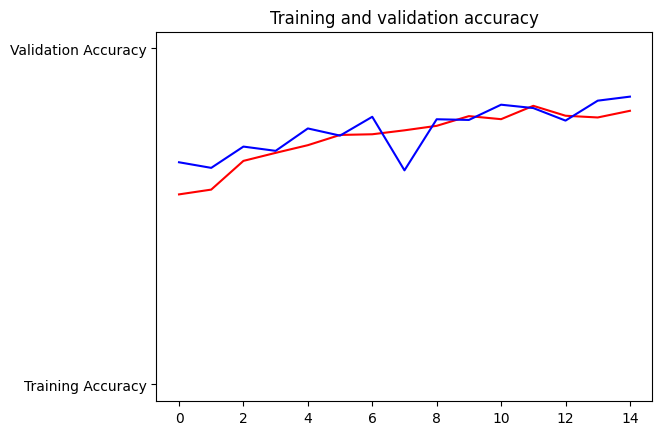

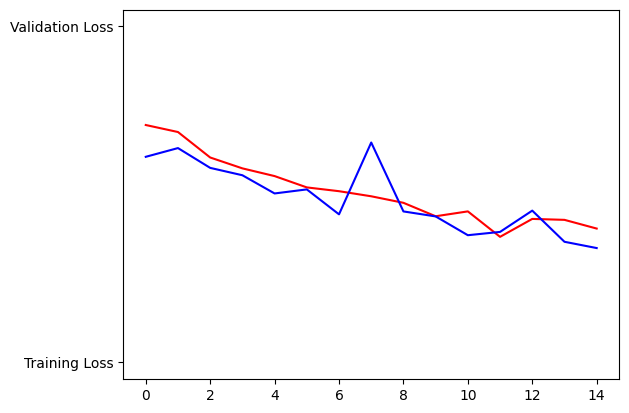

<Figure size 640x480 with 0 Axes>

In [12]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [13]:
# Here's a codeblock just for fun. You should be able to upload an image here
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving download.jpg to download.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
[1.]
download.jpg is a dog
